In [142]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import ROOT
import time
import helpfunction as helper
from __future__ import division

from sklearn.model_selection import train_test_split
import sklearn.svm
from svm_smo import *

In [2]:
#inputdir = '/home/tmettler/Desktop/ub_data/ub_xsec/ConsolidatedSliceAnalyser/ext/'

# CRTinBNB tagger, Overlay or MC

In [3]:
fidvol_vtx = [10,10,10,10,10,50] 
fidvol_end = [5,5,5,5,5,5]

lower = [-1.55, -115.53, 0.1]
upper = [254.8, 117.47, 1036.9]


mass_mu = 0.106
kin_min = 0.02
kin_min_mu = kin_min + mass_mu

gr = (1 + 5 ** 0.5) / 2

In [4]:
def eventHash(df):
    return df.apply(lambda x: hash(tuple(x)), axis = 1)

def inTPC_mask(df, str_x, str_y, str_z, fidvol=[0]*6):
    global upper, lower
    mask_x = df[str_x].between(lower[0]+fidvol[0], upper[0]-fidvol[1])
    mask_y = df[str_y].between(lower[1]+fidvol[2], upper[1]-fidvol[3])
    mask_z = df[str_z].between(lower[2]+fidvol[4], upper[2]-fidvol[5])
    mask = mask_x & mask_y & mask_z
    return mask

def inTPC_df(df, str_x, str_y, str_z, fidvol=[0]*6):
    mask = inTPC_mask(df, str_x, str_y, str_z, fidvol)
    return df[mask]

In [5]:
inputdir = '/home/tmettler/Desktop/ub_data/cc_filter/'
outputdir = '/home/tmettler/Desktop/ub_data/cc_filter/my_plots/'
#inputdir = '/home/tmettler/Desktop/ub_data/cc_filter/wouter/run1/'
#outputdir = '/home/tmettler/Desktop/ub_data/cc_filter/wouter/run1/my_plots/'
try:
    os.stat(outputdir)
except:
    os.mkdir(outputdir)
filename = 'flashID_tree_overlay.root'
#filename = 'flashID_tree_wvdp_overlay_nue.root'
#filename = 'NeutrinoCRTMatcher_QP_Overlay_bigWindow.root'
#filename = 'NeutrinoCRTMatcher_QP_6500_bigWindow.root'
#filename = 'NeutrinoCRTMatcher_QP_EXT_all.root'

isMC = 1
useT1 = 0
nuCCanalyser = 'nuCCAnalyser'

In [6]:
test = ROOT.TChain( nuCCanalyser + '/Event',"Event")
test.Add( inputdir + filename)

#test.ls()
print "Number of Entries:", test.GetEntries()
# uncomment one of them
cutname = 'has_nuslice'

cut = ' && ' + cutname
#cut = ''

title_cut = ''
if(cut!=''):
    title_cut = ' with '+ cutname


Number of Entries: 5625


Warning in <TClass::Init>: no dictionary for class ROOT::TIOFeatures is available


In [7]:
ROOT.gStyle.SetOptStat(0)
c1 = ROOT.TCanvas("","",1600,1200)
c1.SetGrid(1)
c1.SetLeftMargin(0.14)
c1.SetRightMargin(0.18)
c1.SetBottomMargin(0.14)

In [8]:
file_tree = {}
dict_names = ['overlay','on','off']

file_tree['overlay'] = {}
file_tree['overlay']['event'] = uproot.open(inputdir+filename)[nuCCanalyser +'/Event']
file_tree['overlay']['daughter'] = uproot.open(inputdir+filename)[nuCCanalyser + '/Daughters']
file_tree['overlay']['sliceid'] = uproot.open(inputdir+filename)['pandoraSliceId'+'/events']
file_tree['overlay']['slices'] = uproot.open(inputdir+filename)['pandoraSliceId'+'/slices']
print file_tree['overlay']['event'].numentries
print 'length of event tree', file_tree['overlay']['event'].numentries
print file_tree['overlay']['sliceid'].numentries

5625
length of event tree 5625
11893


In [9]:
for name in file_tree['overlay'] :
    print
    print('*** ', name, ' ***')
    #print([c.decode('UTF-8') for c in file_tree['overlay'][name].keys()])


('*** ', 'sliceid', ' ***')

('*** ', 'daughter', ' ***')

('*** ', 'event', ' ***')

('*** ', 'slices', ' ***')


In [10]:
entry_Event = file_tree['overlay']['event'].keys()
print entry_Event
entry_SliceId = file_tree['overlay']['sliceid'].keys()
entry_Daughter = file_tree['overlay']['daughter'].keys()
entry_Slices = file_tree['overlay']['slices'].keys()

cols = ['mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', 'mc_nu_lepton_energy', 'mc_nu_lepton_theta','mc_nu_ccnc', 'mc_nu_pdg']

tree_Event = file_tree['overlay']['event'].pandas.df(cols)
#tree_SliceId = file_tree['overlay']['sliceid'].pandas.df(entry_SliceId)
tree_Daughter = file_tree['overlay']['daughter'].pandas.df(entry_Daughter)
#tree_Slices = file_tree['overlay']['slices'].pandas.df(entry_Slices)


#print 'Number of entries in file', file_tree['overlay']['event'].numentries
#print 'length of event tree', len(tree_Event)
#print 'Shape of event tree', tree_Event.shape
#print 'length of slicid tree', len(tree_SliceId)
#print 'length of daughter tree', len(tree_Daughter)
#print 'length of slices tree', len(tree_Slices)

#query_Event = 'mc_nu_pdg==12'
#query_SliceId = 'nuPdgCode==12'
#num_Event = len(tree_Event.query(query_Event))
#num_Slice = len(tree_SliceId.query(query_SliceId))
#print num_Event
#print num_Slice

tree_Event['mc_nu_fid_vol'] = inTPC_mask( tree_Event, 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', fidvol=fidvol_vtx)
nu_tpc_mask = inTPC_mask( tree_Event, 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz')
#df_nu_event['mc_nu_fid_vol'] = inTPC_mask( df_nu_event, 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', fidvol=fidvol_vtx)
#for numu
nu_sig_mask = tree_Event.eval('mc_nu_lepton_energy>@kin_min_mu & ~mc_nu_ccnc & abs(mc_nu_pdg)==14 & mc_nu_fid_vol')
tree_Event['nu_sig_mask'] = tree_Event.eval('mc_nu_lepton_energy>@kin_min_mu & ~mc_nu_ccnc & abs(mc_nu_pdg)==14 & mc_nu_fid_vol')
## for nue
nu_sig_mask = tree_Event.eval('~mc_nu_ccnc & abs(mc_nu_pdg)==14 & mc_nu_fid_vol')
tree_Event['nu_sig_mask'] = tree_Event.eval('~mc_nu_ccnc & abs(mc_nu_pdg)==14 & mc_nu_fid_vol')


#nu_sig_mask = tree_Event.eval('~mc_nu_ccnc & abs(mc_nu_pdg)==12 & mc_nu_fid_vol')

print sum(nu_tpc_mask)
print sum(nu_sig_mask)

['event', 'run', 'subrun', 'evt_time_sec', 'evt_time_nsec', 'numpfp', 'hitsU', 'hitsV', 'hitsY', 'caloU', 'caloV', 'caloY', 'hitsSps', 'num_primary_daughters', 'num_daughters', 'num_showers', 'num_tracks', 'daughters_stored', 'nu_vx', 'nu_vy', 'nu_vz', 'nu_pdg', 'num_neutrinos', 'mc_nu_vx', 'mc_nu_vy', 'mc_nu_vz', 'mc_nu_vx_sce', 'mc_nu_vy_sce', 'mc_nu_vz_sce', 'mc_nu_energy', 'mc_nu_px', 'mc_nu_py', 'mc_nu_pz', 'mc_nu_lepton_energy', 'mc_nu_lepton_px', 'mc_nu_lepton_py', 'mc_nu_lepton_pz', 'mc_nu_lepton_theta', 'mc_nu_time', 'mc_nu_pdg', 'mc_nu_interaction_type', 'mc_nu_ccnc', 'mc_nu_vtx_distance', 'num_matched_daughters', 'cosmic_matched', 'mc_nu_daughter_matched', 'mc_nu_daughter_pdg', 'mc_nu_daughter_energy']
3873
2730


In [11]:
start = time.time()
start_mask = inTPC_mask(tree_Daughter, 'vx', 'vy', 'vz', fidvol_vtx)

tree_Daughter['hash'] = eventHash(tree_Daughter[['evt_time_sec', 'evt_time_nsec']])

df_event = file_tree['overlay']['event'].pandas.df(['evt_time_sec','evt_time_nsec','nu_pdg', 'caloY','num_tracks'])
df_event['hash'] = eventHash(df_event[['evt_time_sec', 'evt_time_nsec']])
mapper = dict(zip(df_event['hash'],df_event['nu_pdg']))
tree_Daughter['nu_pdg'] = tree_Daughter['hash'].map(mapper)
mapper = dict(zip(df_event['hash'],df_event['caloY']))
tree_Daughter['caloY'] = tree_Daughter['hash'].map(mapper)
mapper = dict(zip(df_event['hash'],df_event['num_tracks']))
tree_Daughter['num_tracks'] = tree_Daughter['hash'].map(mapper)
mapper = dict(zip(df_event['hash'],tree_Event['nu_sig_mask']))
tree_Daughter['nu_sig_mask'] = tree_Daughter['hash'].map(mapper)

df_slices = file_tree['overlay']['slices'].pandas.df(['evt_time_sec','evt_time_nsec','topologicalScore', 'flashMatchScore', 'isTaggedAsTarget', 'minCRTdist','purity'])
df_slices = df_slices.query('isTaggedAsTarget')
df_slices['hash'] = eventHash(df_slices[['evt_time_sec', 'evt_time_nsec']])
mapper = dict(zip(df_slices['hash'],df_slices['topologicalScore']))
tree_Daughter['topologicalScore'] = tree_Daughter['hash'].map(mapper)
mapper = dict(zip(df_slices['hash'],df_slices['flashMatchScore']))
tree_Daughter['flashMatchScore'] = tree_Daughter['hash'].map(mapper)
mapper = dict(zip(df_slices['hash'],df_slices['minCRTdist']))
tree_Daughter['minCRTdist'] = tree_Daughter['hash'].map(mapper)
mapper = dict(zip(df_slices['hash'],df_slices['purity']))
tree_Daughter['purity'] = tree_Daughter['hash'].map(mapper)

print tree_Daughter.shape
end = time.time()
print("Passed time: {0:0.1f}s".format(end - start))

(12911, 65)
Passed time: 0.8s


In [12]:
start = time.time()
tree_Daughter['longest_track_length'] = tree_Daughter.groupby(['hash'])['track_length'].transform(max)
# there can be only one muon candidate per event!
tree_Daughter['muon_candidate'] = tree_Daughter.eval('track_score>0.9 & vtx_distance<5 & longest_track_length==track_length')
tree_Daughter['all_muon_candidate'] = tree_Daughter.groupby(['hash'])['muon_candidate'].transform(any)

df_all_event = file_tree['overlay']['sliceid'].pandas.df(['evt_time_sec','evt_time_nsec','bestCosmicMatch'])
df_all_event['hash'] = eventHash(df_all_event[['evt_time_sec', 'evt_time_nsec']])
mapper = dict(zip(df_all_event['hash'],df_all_event['bestCosmicMatch']))
tree_Daughter['bestCosmicMatch'] = tree_Daughter['hash'].map(mapper)

if isMC == 1:
    mapper = dict(zip(df_event['hash'],nu_tpc_mask))
    tree_Daughter['mc_nu_in_tpc'] = tree_Daughter['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],nu_sig_mask))
    tree_Daughter['mc_nu_cc_sig'] = tree_Daughter['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],file_tree['overlay']['event'].array('mc_nu_lepton_energy')))
    tree_Daughter['mc_nu_lepton_energy'] = tree_Daughter['hash'].map(mapper)
    mapper = dict(zip(df_event['hash'],file_tree['overlay']['event'].array('mc_nu_lepton_theta')))
    tree_Daughter['mc_nu_lepton_theta'] = tree_Daughter['hash'].map(mapper)
end = time.time()
print("Passed time: {0:0.1f}s".format(end - start))

#print tree_Daughter
print tree_Daughter.shape
#num_Daughter_nue = len(tree_Daughter.query('nu_pdg==12'))

Passed time: 2.2s
(12911, 73)


In [13]:
tree_Daughter['start_contained'] = start_mask
#print len(tree_Daughter)
tree_Daughter_nuCC = tree_Daughter.query('mc_nu_cc_sig')
#print len(tree_Daughter_nuCC)
#query_event = 'nu_pdg==14 & (flashMatchScore<10 | topologicalScore>0.4) & start_contained & muon_candidate & topologicalScore>0.087 & (flashMatchScore/bestCosmicMatch)<4 & track_length>30 & minCRTdist>15'

query_event = 'nu_pdg==14 & (flashMatchScore<10 | topologicalScore>0.4) & start_contained & muon_candidate & topologicalScore>0.087 & (flashMatchScore/bestCosmicMatch)<4'
query_event = query_event +' & track_length>30'
##
# additinal cuts:
add_query = '& (caloU/track_length)<0.003'
query_event += add_query
#query_event = 'nu_pdg!=0'
#query_event = 'nu_pdg==12 & (flashMatchScore<10 | topologicalScore>0.4) & start_contained & topologicalScore>0.087 & (flashMatchScore/bestCosmicMatch)<4 & minCRTdist>15'

eff = len(tree_Daughter_nuCC.query(query_event))
print 'number of initial events:', sum(nu_sig_mask)
print 'number of selected events:', eff

eff = eff*100.0/sum(nu_sig_mask)
print eff

number of initial events: 2730
number of selected events: 1551
56.8131868132


The denominator (2730,)
The nominator (1551,)


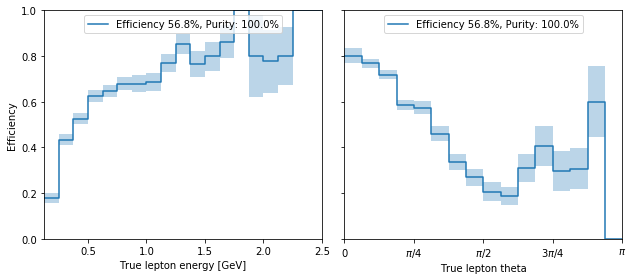

In [14]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5.5*gr,4), sharey=True)
purity = 1
x_min = 0.125
x_max = 2.5
N = 19
denom = tree_Event['mc_nu_lepton_energy'][nu_sig_mask]
print 'The denominator', denom.shape
nom = tree_Daughter_nuCC.query(query_event)['mc_nu_lepton_energy']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[0].set_xlabel(r'True lepton energy [GeV]')
ax[0].set_ylabel('Efficiency')
ax[0].set_ylim(0,1)
ax[0].set_xlim(x_min, x_max)
ax[0].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[0].legend(loc='upper center')

# Right
x_ticks = [0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]
x_labels = [r'$0$',r'$\pi/4$',r'$\pi/2$',r'$3\pi/4$',r'$\pi$']
x_min = 0
x_max = np.pi
N = 16
denom = tree_Event['mc_nu_lepton_theta'][nu_sig_mask]
nom = tree_Daughter_nuCC.query(query_event)['mc_nu_lepton_theta']
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 
ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[1].set_xlabel(r'True lepton theta')
ax[1].set_ylim(0,1)
ax[1].set_xlim(x_min, x_max)
ax[1].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[1].legend(loc='upper center')
ax[1].set_xticks(x_ticks)
ax[1].set_xticklabels(x_labels)


fig.tight_layout()
fig.savefig(outputdir+"eff.pdf", bbox_inches="tight")

In [15]:
#query_event = 'nu_pdg==14 & (flashMatchScore<10 | topologicalScore>0.4) & start_contained & muon_candidate & topologicalScore>0.087 & (flashMatchScore/bestCosmicMatch)<4 & track_length>30 & minCRTdist>15'
for col in tree_Daughter_nuCC.columns: 
    print(col) 

event
run
subrun
evt_time_sec
evt_time_nsec
hitsU
hitsV
hitsY
caloU
caloV
caloY
hitsSps
generation
track_score
is_shower
is_track
has_shower_daughter
is_track_daughter
vx
vy
vz
vtx_distance
track_length
track_endx
track_endy
track_endz
track_dirx
track_diry
track_dirz
track_mcs_mom
track_mcs_err
track_mcs_ll
track_chi2_proton
track_chi2_muon
shower_length
shower_openangle
shower_dirx
shower_diry
shower_dirz
start_dedxU
start_dedxV
start_dedxY
start_hitsU
start_hitsV
start_hitsY
start_pitchU
start_pitchV
start_pitchY
mc_neutrino
mc_vx
mc_vy
mc_vz
mc_vx_sce
mc_vy_sce
mc_vz_sce
mc_energy
mc_pdg
hash
nu_pdg
num_tracks
nu_sig_mask
topologicalScore
flashMatchScore
minCRTdist
purity
longest_track_length
muon_candidate
all_muon_candidate
bestCosmicMatch
mc_nu_in_tpc
mc_nu_cc_sig
mc_nu_lepton_energy
mc_nu_lepton_theta
start_contained


The denominator (2184,)
The nominator (1551,)
The denominator (2184,)
The nominator (1551,)


/home/tmettler/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


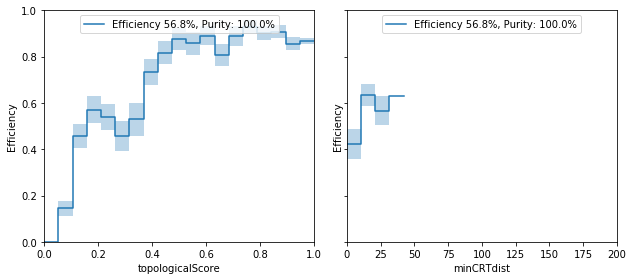

In [16]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5.5*gr,4), sharey=True)
purity = 1
x_min = 0
x_max = 1
N = 19

#denom = tree_Event['mc_nu_lepton_energy'][nu_sig_mask]
denom = tree_Daughter_nuCC.query('nu_sig_mask == 1 & muon_candidate')['topologicalScore']
#print (nu_sig_mask)
print 'The denominator', denom.shape
nom = tree_Daughter_nuCC.query(query_event)['topologicalScore']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[0].set_xlabel(r'topologicalScore')
ax[0].set_ylabel('Efficiency')
ax[0].set_ylim(0,1)
ax[0].set_xlim(x_min, x_max)
ax[0].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[0].legend(loc='upper center')

# Right
x_min = 0
x_max = 200
#denom = tree_Event['mc_nu_lepton_energy'][nu_sig_mask]
denom = tree_Daughter_nuCC.query('nu_sig_mask == 1 & muon_candidate')['minCRTdist']
#print (nu_sig_mask)
print 'The denominator', denom.shape
nom = tree_Daughter_nuCC.query(query_event)['minCRTdist']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[1].set_xlabel(r'minCRTdist')
ax[1].set_ylabel('Efficiency')
ax[1].set_ylim(0,1)
ax[1].set_xlim(x_min, x_max)
ax[1].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[1].legend(loc='upper center')



fig.tight_layout()
fig.savefig(outputdir+"eff.pdf", bbox_inches="tight")

The denominator (2184,)
The nominator (1551,)
The denominator (2184,)
The nominator (1551,)


/home/tmettler/.local/lib/python2.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app
/home/tmettler/.local/lib/python2.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: invalid value encountered in true_divide


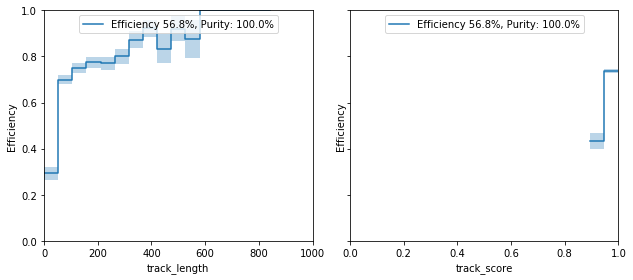

In [17]:
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(5.5*gr,4), sharey=True)
purity = 1
x_min = 0
x_max = 1000
N = 19

#denom = tree_Event['mc_nu_lepton_energy'][nu_sig_mask]
denom = tree_Daughter_nuCC.query('nu_sig_mask == 1 & muon_candidate')['track_length']
#print (nu_sig_mask)
print 'The denominator', denom.shape
nom = tree_Daughter_nuCC.query(query_event)['track_length']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[0].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[0].set_xlabel(r'track_length')
ax[0].set_ylabel('Efficiency')
ax[0].set_ylim(0,1)
ax[0].set_xlim(x_min, x_max)
ax[0].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[0].legend(loc='upper center')

# Right
x_min = 0
x_max = 1
#denom = tree_Event['mc_nu_lepton_energy'][nu_sig_mask]
denom = tree_Daughter_nuCC.query('nu_sig_mask == 1 & muon_candidate')['track_score']
#print (nu_sig_mask)
print 'The denominator', denom.shape
nom = tree_Daughter_nuCC.query(query_event)['track_score']
print 'The nominator', nom.shape
data = [denom, nom]
edges, _, bins, _, _ = helper.histHelper(N,x_min,x_max,data)
fraq = bins[1]/bins[0]
err = np.sqrt( fraq*(1-fraq)/bins[0] )
fraq= np.append(fraq,fraq[-1])
err = np.append(err,err[-1]) 

ax[1].fill_between(edges, fraq - err, fraq + err, alpha=0.3, step='post')
ax[1].set_xlabel(r'track_score')
ax[1].set_ylabel('Efficiency')
ax[1].set_ylim(0,1)
ax[1].set_xlim(x_min, x_max)
ax[1].step(edges, fraq, where='post', label = r'Efficiency {0:0.1f}%, Purity: {1:0.1f}%'.format(eff,purity*100))
ax[1].legend(loc='upper center')



fig.tight_layout()
fig.savefig(outputdir+"eff.pdf", bbox_inches="tight")

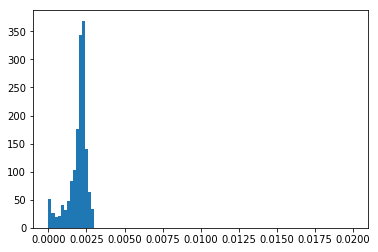

In [18]:

plt.hist(tree_Daughter_nuCC.query(query_event)['caloU'] / tree_Daughter_nuCC.query(query_event)['track_length'] , bins=100, range=[0,0.02])
#plt.hist(tree_Daughter_nuCC.query(query_event)['track_length'], bins=100, range=[0,500])
x_min = 0
x_max = 500

In [19]:
import collections
#a = tree_Daughter_nuCC.query(query_event)['mc_pdg']
# 2212=proton , 211=Pi+, 11=electron, 2112=neutron, 321=K+, 22=gamma, 3222=sigma+
counter=collections.Counter(tree_Daughter_nuCC.query(query_event)['mc_pdg'])
print(counter)
print len(tree_Daughter_nuCC.query(query_event)['mc_pdg'])
print 'Initial nues in fiducial volume:', sum(tree_Event.eval('~mc_nu_ccnc & abs(mc_nu_pdg)==12 & mc_nu_fid_vol') )

Counter({13: 1445, 2212: 42, 211: 39, -13: 14, 2112: 6, 321: 2, -211: 2, 22: 1})
1551
Initial nues in fiducial volume: 18


event


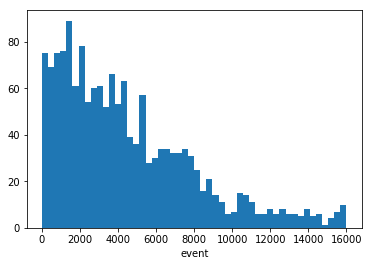

run


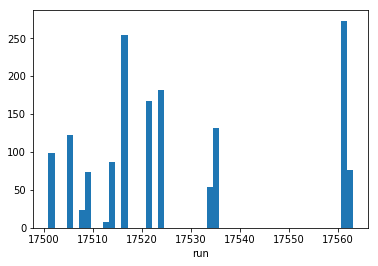

subrun


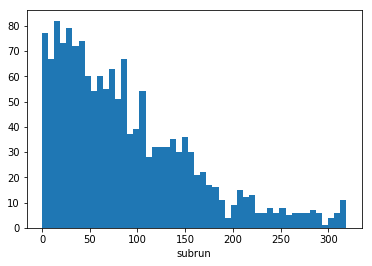

evt_time_sec


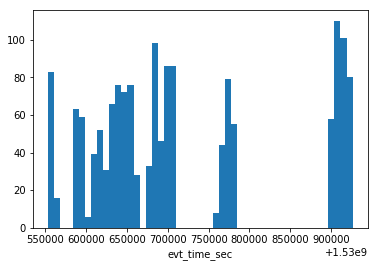

evt_time_nsec


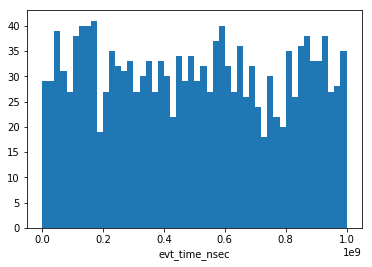

hitsU


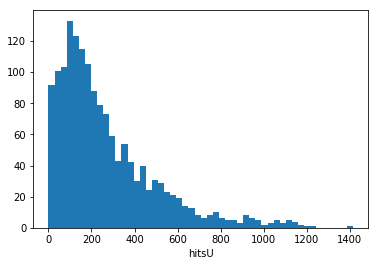

hitsV


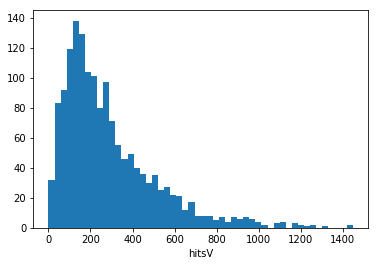

hitsY


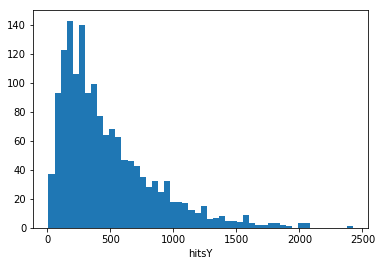

caloU


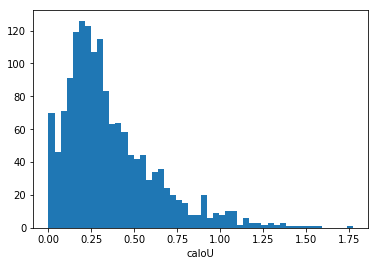

caloV


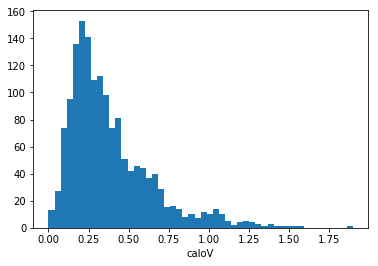

caloY


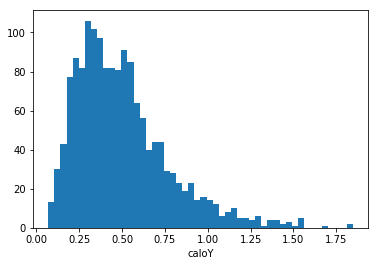

hitsSps


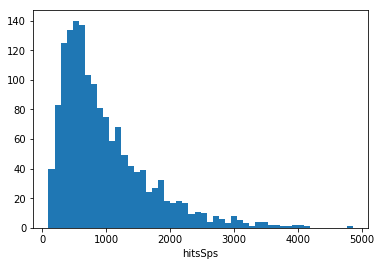

generation


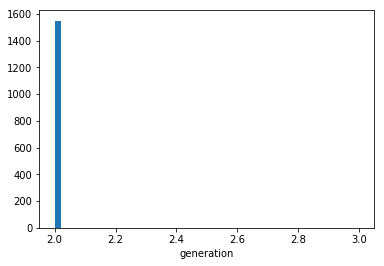

track_score


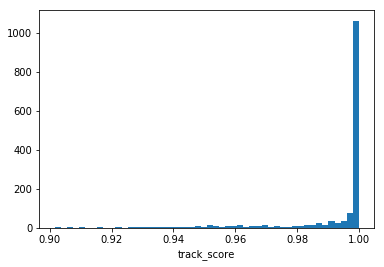

is_shower


/home/tmettler/.local/lib/python2.7/site-packages/numpy/lib/histograms.py:778: RuntimeWarning: Converting input from bool to <type 'numpy.uint8'> for compatibility.
  a, weights = _ravel_and_check_weights(a, weights)


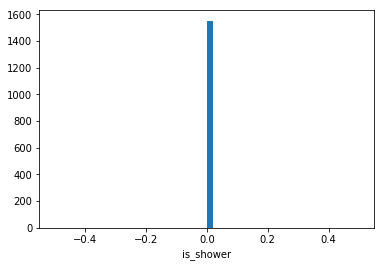

is_track


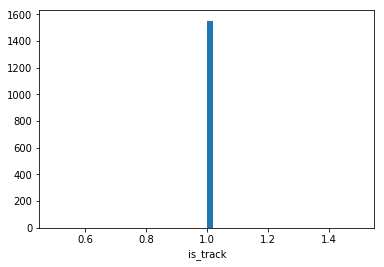

has_shower_daughter
is_track_daughter


TypeError: numpy boolean subtract, the `-` operator, is deprecated, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

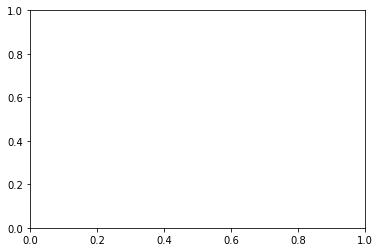

In [20]:
#for col in tree_Daughter_nuCC.columns: 
#    print(col) 

for key in tree_Daughter_nuCC.columns: 
    print key
    if key!='has_shower_daughter' and key!='hash' :
        plt.hist(tree_Daughter_nuCC.query(query_event)[key.decode("utf-8")], bins=50)
        plt.xlabel(key.decode("utf-8"))
        plt.show()

In [104]:
#a = np.zeros(len(tree_Daughter_nuCC.query(query_event)['track_length']))
tracklen_arr = tree_Daughter['track_chi2_proton'].values
caloU_arr = tree_Daughter['track_chi2_muon'].values

is_muon = tree_Daughter.eval('abs(mc_pdg)==13').values

#is_muon[is_muon == True] = 1
is_muon = is_muon*1
is_muon[is_muon == 0] =-1

print is_muon
print len(is_muon)

#a.reshape((2,1))
#print a
combined = np.vstack((tracklen_arr, caloU_arr)).T
#plt.plot(combined[:,0],combined[:,1],'r+')
#print combined


[-1 -1  1 ... -1 -1 -1]
12911


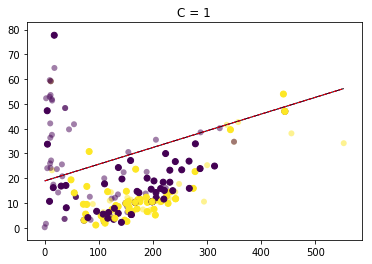

In [152]:
# Set model parameters and initial values
kernel = 'lin'

combined_small = combined[:200,:200]
is_muon_small = is_muon[:200]

#is_muon[is_muon == True] = 1
#is_muon[is_muon == False] =-1

if(kernel == 'lin'):
    C = 1
    m = len(combined_small)
    initial_alphas = np.zeros(m)
    initial_b = 0.0

    # Instantiate model
    model = SMOModel(combined_small, is_muon_small, C, linear,initial_alphas, initial_b, np.zeros(m))

    # Initialize error cache
    initial_error = decision_function(model.alphas, model.y, model.kernel, model.X, model.X, model.b) - model.y
    model.errors = initial_error

    # Train the model
    np.random.seed(0)
    output = train(model)

    # Plot results
    fig, ax = plt.subplots()
    grid, ax = plot_decision_boundary(output, ax)
    plt.title('C = ' + str(C))
    plt.show()
if (kernel == 'gaus'):
    # Set model parameters and initial values
    C = 10
    m = len(combined)
    initial_alphas = np.zeros(m)
    initial_b = 0.0

    # Instantiate model
    model = SMOModel(combined, is_muon, C, gaussian,initial_alphas, initial_b, np.zeros(m))

    # Initialize error cache
    initial_error = decision_function(model.alphas, model.y, model.kernel,model.X, model.X, model.b) - model.y
    model.errors = initial_error

    # Train the model
    np.random.seed(0)
    output = train(model)

    # Plot results
    fig, ax = plt.subplots()
    grid, ax = plot_decision_boundary(output, ax)
    plt.title('C = ' + str(C))
    plt.show()

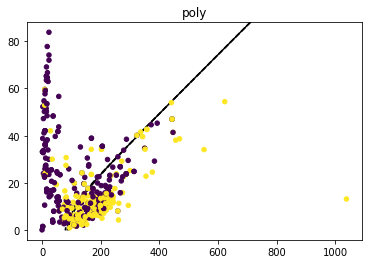

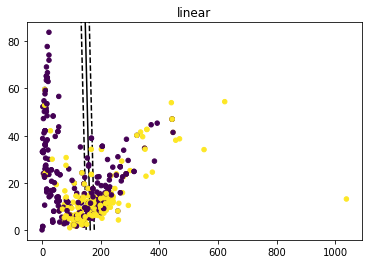

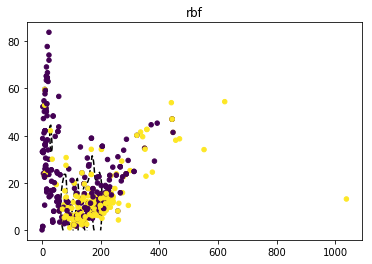

In [174]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

#iris = datasets.load_iris()
#X = iris.data
#y = iris.target

#X = X[y != 0, :2]
#y = y[y != 0]

#n_sample = len(combined)
n_sample = 900

np.random.seed(0)
#order = np.random.permutation(n_sample)
#combined = combined[order]
#is_muon = is_muon[order].astype(np.float)

X_train = combined[:int(.9 * n_sample)]
y_train = is_muon[:int(.9 * n_sample)]
X_test = combined[int(.9 * n_sample):]
y_test = is_muon[int(.9 * n_sample):]

# fit the model
C= 0.1
gamma = 0.01

#for fig_num, kernel in enumerate(('linear', 'rbf', 'poly')):
for fig_num, kernel in enumerate(('poly','linear','rbf')):
    
    #clf = SVC(C=C, kernel=kernel,gamma=gamma, max_iter=100)
    clf = SVC(C=C, kernel=kernel,gamma=gamma, max_iter=100)
    clf.fit(combined,is_muon)

    plt.figure(fig_num)
    plt.clf()
    plt.scatter(combined[:, 0], combined[:, 1], c=is_muon, zorder=10, s=20)
    plt.axis('tight')
    x_min = 0
    x_max = 1000
    y_min = 0
    y_max = 100
    XX, YY = np.mgrid[x_min:x_max:200j, y_min:y_max:200j]
    Z = clf.decision_function(np.c_[XX.ravel(), YY.ravel()])

    # Plot the results
    Z = Z.reshape(XX.shape)
    plt.contour(XX, YY, Z, colors=['k', 'k', 'k'],
                linestyles=['--', '-', '--'], levels=[-.5, 0, .5])

    plt.title(kernel)
plt.show()